# Libraries

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from numpy.random import randint as rnd
from numpy.random import choice
from scipy.optimize import curve_fit
from multiprocessing import Pool
from qiskit import QuantumCircuit as QC
from qiskit import *
from qiskit_aer import AerSimulator
#from qiskit_ibm_runtime import QiskitRuntimeService as QRS
#from qiskit_ibm_runtime import Session, Sampler
from os import cpu_count
from tqdm import tqdm
from datetime import datetime
from pylatexenc import *
from qiskit.quantum_info import Statevector

# Circuit functions

In [2]:
def basis(q:QuantumCircuit):
    bit_a = choice(np.array([0,1,2]))
    bit_b = choice(np.array([1,2,3]))
    #bit_a = rnd(0,3)
    #bit_b = rnd(1,4)
    q.barrier()
    q.ry(bit_a*np.pi/4,0)
    q.ry(bit_b*np.pi/4,1)
    q.barrier()
    q.measure(0,0)
    q.measure(1,1)
    return [q,int(bit_a),int(bit_b)]

def singlet_maker(phase:float):
    q = QC(2,2)
    q.x(0)
    q.x(1)
    q.h(0)
    q.p(phase,0)
    q.cx(0,1)
    info_vector = basis(q)
    q.compose(info_vector[0])
    return [q,info_vector[1],info_vector[2]]

def circuit_list_maker(n_states:int,phase:float):   
    theta = [phase for k in range(n_states)]
    with Pool(cpu_count()) as p:
        circ_list_info = p.map(singlet_maker,theta)
    return circ_list_info

def circuit_info_selector(circ_info_part_list:list):
    circuits = list()
    for k in range(len(circ_info_part_list)):
        circuits.append(circ_info_part_list[k][0])
    return circuits

def exec_basis_selector(circ_info_part_list:list):
    info_vector = list()
    for k in range(len(circ_info_part_list)):
        info_vector.append(circ_info_part_list[k][1:3])
    return info_vector

In [3]:
c = singlet_maker(0)
circ = c[0]
display(circ.draw())
#display(Statevector(circ).draw(output='latex'))
print(c[1:3])

┌───┐┌───┐┌──────┐      ░ ┌─────────┐ ░ ┌─┐   
q_0: ┤ X ├┤ H ├┤ P(0) ├──■───░─┤ Ry(π/4) ├─░─┤M├───
     ├───┤└───┘└──────┘┌─┴─┐ ░ ├─────────┤ ░ └╥┘┌─┐
q_1: ┤ X ├─────────────┤ X ├─░─┤ Ry(π/2) ├─░──╫─┤M├
     └───┘             └───┘ ░ └─────────┘ ░  ║ └╥┘
c: 2/═════════════════════════════════════════╩══╩═
                                              0  1

[1, 2]


# Post execution functions

In [4]:
def info_vector_maker(n_states:int):
    return [[int(0) for l in range(4)] for k in range(n_states)]

def info_vector_basis_fill(basis_vector:list,info_vector:list):
    for k in range(len(basis_vector)):
        info_vector[k][0]=basis_vector[k][0]
        info_vector[k][1]=basis_vector[k][1]
    return info_vector

def result_key_session(result_info):
    result_bin = [result_info.quasi_dists[l].binary_probabilities(2) for l in range(len(result_info.quasi_dists))]
    result_vector = list()
    for k in range(len(result_bin)):
        result_vector.append(*result_bin[k])
    return result_vector

def result_key_local(result_info:list):
    result_vector = list()
    for k in range(len(result_info)):
        result = result_info[k]
        result_vector.append(*result)
    return result_vector
    
def result_processing(result_vector:list,info_vector:list):
    for k in range(len(result_vector)):
        if result_vector[k]=='11':
            info_vector[k][2]=1
            info_vector[k][3]=1
        elif result_vector[k]=='01':
            info_vector[k][3]=1
        elif result_vector[k]=='10':
            info_vector[k][2]=1
        elif result_vector[k]=='00':
            pass
    return info_vector 

# classical computing part

In [5]:
def anticorrelation_factor(info_vector:list):
    n_basis_equal = 0
    n_anticorrelation = 0
    basis_a = [info_vector[k][0] for k in range(len(info_vector))]
    basis_b = [info_vector[k][1] for k in range(len(info_vector))]
    bit_a = [info_vector[k][2] for k in range(len(info_vector))]
    bit_b = [info_vector[k][3] for k in range(len(info_vector))]
    for k in range(len(info_vector)):
        if basis_a[k]==basis_b[k]:
            n_basis_equal += 1
            if bit_a[k]!=bit_b[k]:
                n_anticorrelation += 1
            else:
                pass
        else:
            pass
    return n_anticorrelation/n_basis_equal

def encoding_key(m):
    n_basis_equal = 0
    n_anticorrelation = 0
    for k in range(len(m)):
        if m[k][0]==m[k][1]:
            # verifica que  las bases sean las mismas
            n_basis_equal = n_basis_equal + 1
            if m[k][2]==int(not(bool(m[k][3]))):
                # verifica que haya anticorrelación
                n_anticorrelation =  n_anticorrelation + 1
            else:
                pass
        else:
            pass
    fidelity = n_anticorrelation/n_basis_equal
    return fidelity

def save_info_to_csv(theta:list,fidelity:list,backend_name,time_str):
    file_name = f"data_{backend_name}_{time_str}.csv"
    np.savetxt(file_name,[[theta[k],fidelity[k]]for k in range(len(fidelity))],delimiter=",")


# Analysis functions

In [6]:
def func_fit(x,A:float,w:float,d:float,b:float):
    return A * np.cos(w*x + d) + b

def r2(y_exp,y_fit):
    Dy = y_exp - y_fit
    Dy2_sum = np.sum(Dy**2)
    tot_sum = np.sum((y_exp-np.mean(y_exp))**2)
    return 1. - (Dy2_sum/tot_sum)

def fit(theta:list,fidelity:list):
    popt, pcov = curve_fit(func_fit,theta,fidelity)
    r_squared_fit = r2(func_fit(theta,*popt),func_fit(theta,0.25,1.,0.,0.75))
    formula = f"Fit -> $P(\\theta) = {popt[0]:1.4f} \cos( {popt[1]:1.4f} \\theta + {popt[2]:1.4e} ) + {popt[3]:1.4f} $"
    print(formula)
    print(f"R^2 = {r_squared_fit}")
    return popt


def plots(theta:list,fidelity,popt:list):
    plt.plot(theta,fidelity,'.r',label="exp data")
    plt.plot(theta,func_fit(theta,*popt),'--k', label="fit")
    plt.plot(theta,func_fit(theta,0.25,1.,0.,0.75),'-b',label="theoretical")

    plt.legend(loc="lower left")
    plt.show()


<>:13: SyntaxWarning: invalid escape sequence '\c'
<>:13: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_65288/3446218809.py:13: SyntaxWarning: invalid escape sequence '\c'
  formula = f"Fit -> $P(\\theta) = {popt[0]:1.4f} \cos( {popt[1]:1.4f} \\theta + {popt[2]:1.4e} ) + {popt[3]:1.4f} $"


# Execution type

## IBMQ

In [7]:
def circcuit_list_maker():
    circ_list = list()
    circuits_info = circuit_list_maker(n_states=n_states,phase=theta[k])
    circuits = circuit_info_selector(circuits_info)

In [8]:
def join_info(fidelity_list:list):
    n_parts = len (fidelity_list)
    n_elements = len (fidelity_list[0])
    fidelity = list()
    for l in range(n_parts):
        for k in range(n_elements):
            fidelity.append(fidelity_list[l][k])
    return fidelity

In [9]:
def run_session(n_states:int,n_execs:int,n_parts:int,theta:list):
    fidelity_list = list()

    # conection with ibmq

    print("Connecting with IBMQ ...")
    service = QRS()
    print("Connected\n")

    #backend = service.get_backend('ibmq_qasm_simulator')
    backend = service.get_backend('ibmq_quito')
    print(f"Backend used: {backend.name}\n")

    sampler = Sampler(backend=backend)
    sampler.set_options(shots=1)

    # session creation
    now = datetime.now().strftime("%d_%m_%Y_%H_%M")
    print(f"Session opened at {now}")

    
    with Session(service=service,backend=backend) as session:
        n_elements = int(len(theta)/n_parts)
        for l in range(n_parts):
            
            print(f"run {l+1}")
            theta_part = [theta[n_elements*l+k] for k in range(n_elements)]
            
            circuits_info = [circuit_list_maker(n_states=n_states,phase=theta_part[k]) for k in range(n_elements)]
            print("circuits created")
            circuits = [circuit_info_selector(circuits_info[k]) for k in range(n_elements)]
            basis_vector = [exec_basis_selector(circuits_info[k])for k in range(n_elements)]
            circuits_info = list()
            
            measurement_information = [info_vector_maker(n_states) for k in range(n_elements)]
            measurement_information = [info_vector_basis_fill(basis_vector[k],measurement_information[k])for k in range(n_elements)]
            
            # Quasi-Probability calculation
            job_list = [sampler.run(circuits[k]) for k in range(n_elements)]
            print("jobs done")
            result = [job_list[k].result() for k in range(n_elements)]
            print("extracting results ...")
            result_vector = [result_key_session(result[k]) for k in range(n_elements)]
            print("done")
            
            measurement_information = [result_processing(result_vector[k],measurement_information[k])for k in range(n_elements)]
            fidelity=[anticorrelation_factor(measurement_information[k])for k in range(n_elements)]
            fidelity_list.append(fidelity)
            save_info_to_csv(theta,fidelity,backend.name,time_str=now)
        
        session.close()
    print("Session closed")
    
    return join_info(fidelity_list)

## Local

In [10]:
def local_simulation_run(circ:QuantumCircuit):
    simulator = AerSimulator()
    circ = transpile(circ, simulator)
    result = simulator.run(circ,shots=1).result()
    return result.get_counts()

def run_local(n_states:int,n_execs:int,theta:list):
    fidelity = list()
    measurement_information_vector = list()
    print(f"Backend used: aer_simulator\n")
    now = datetime.now().strftime("%d_%m_%Y_%H_%M")
    for k in tqdm(range(n_execs),desc="Execution"):
        circuits_info = circuit_list_maker(n_states=n_states,phase=theta[k])
        circuits = circuit_info_selector(circuits_info)
        basis_vector = exec_basis_selector(circuits_info)
        measurement_information = info_vector_maker(n_states)
        measurement_information = info_vector_basis_fill(basis_vector,measurement_information)
        # Quasi-Probability calculation
        with Pool(cpu_count()) as p:
            result = p.map(local_simulation_run,circuits)
        result_vector = result_key_local(result)
        measurement_information = result_processing(result_vector,measurement_information)
        fidelity.append(anticorrelation_factor(measurement_information))
        measurement_information_vector.append(measurement_information)
        #fidelity.append(encoding_key(measurement_information))
        save_info_to_csv(theta,fidelity,"aer_simulator",time_str=now)
        
    return fidelity

# Main


Backend used: aer_simulator



Execution:   0%|          | 0/20 [00:00<?, ?it/s]

Execution: 100%|██████████| 20/20 [12:45<00:00, 38.29s/it]

Fit -> $P(\theta) = 0.3646 \cos( 0.9954 \theta + 1.0612e-02 ) + 0.6355 $
R^2 = 0.725864656650757


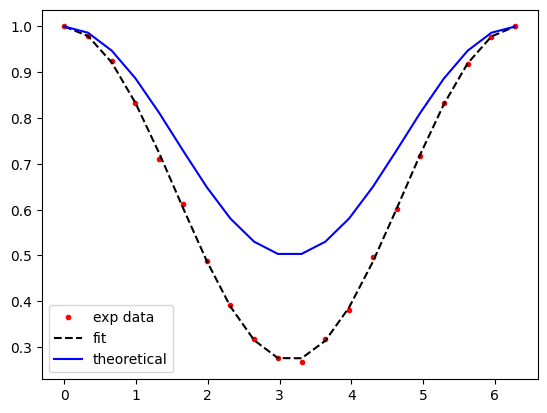

In [11]:
if __name__=="__main__":

    # execution options

    n_states = int(3e4)
    n_execs = int(1e2/5)
    n_parts = 6
    
    theta = np.linspace(0,2*np.pi,n_execs)

    # on ibm-quantum
    #fidelity = run_session(n_states,n_execs,n_parts,theta)

    # on local host
    fidelity = run_local(n_states,n_execs,theta)
    
    popt = fit(theta,fidelity)
    plots(theta,fidelity,popt)
    